# 8. Convolutional Neural Networks

I recommend you take a look at these material first.

* http://www.aclweb.org/anthology/D14-1181
* https://github.com/Shawn1993/cnn-text-classification-pytorch
* http://cogcomp.org/Data/QA/QC/

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
import re
from copy import deepcopy
flatten = lambda l: [item for sublist in l for item in sublist]
random.seed(1024)

USE_CUDA = torch.cuda.is_available()
gpus = [0]
# torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [2]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch

    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [3]:
def pad_to_batch(batch):
    x,y = zip(*batch)
    max_x = max([s.size(1) for s in x])
    x_p = []
    for i in range(len(batch)):
        if x[i].size(1) < max_x:
            x_p.append(torch.cat([x[i], Variable(LongTensor([word2index['<PAD>']] * (max_x - x[i].size(1)))).view(1, -1)], 1))
        else:
            x_p.append(x[i])
    return torch.cat(x_p), torch.cat(y).view(-1)

In [4]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

## Data load & Preprocessing

### TREC question dataset(http://cogcomp.org/Data/QA/QC/)

Task involves
classifying a question into 6 question
types (whether the question is about person,
location, numeric information, etc.)

In [5]:
import codecs
data = codecs.open('../dataset/train_5500.label.txt', 'r', encoding='latin-1').readlines()
data = [[d.split(':')[1][:-1], d.split(':')[0]] for d in data]
X, y = list(zip(*data))
X = list(X)

### Num masking 

It reduces the search space. ex. my birthday is 12.22 ==> my birthday is ##.##
这是常见的数据预处理手段。

In [6]:
for i, x in enumerate(X):
    X[i] = re.sub('\d', '#', x).split()

### Build Vocab 

In [7]:
vocab = list(set(flatten(X)))
len(vocab)
len(set(y)) # num of class

6

In [8]:
word2index = {'<PAD>': 0, '<UNK>': 1}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
index2word = {v: k for k, v in word2index.items()}

target2index = {}
for cl in set(y):
    if target2index.get(cl) is None:
        target2index[cl] = len(target2index)
index2target = {v: k for k, v in target2index.items()}

In [9]:
X_p, y_p = [], []
for pair in zip(X,y):
    X_p.append(prepare_sequence(pair[0], word2index).view(1, -1))
    y_p.append(Variable(LongTensor([target2index[pair[1]]])).view(1, -1))
    
data_p = list(zip(X_p, y_p))
random.shuffle(data_p)

train_data = data_p[: int(len(data_p) * 0.9)]
test_data = data_p[int(len(data_p) * 0.9):]

### Load Pretrained word vector

使用预训练embedding的时候，word2index的序号要对齐。/Users/wangming/nltk_data/glove.6B.50d.txt

In [10]:
# 加载glove预训练词向量
import bcolz, numpy as np
import pickle

glove_path = '/Users/wangming/nltk_data/glove.6B.50d.txt'
glove_dir = glove_path[0:glove_path.rfind('/')]
words = []
idx = 0
word2idx = {}
glove_vec_path = glove_dir+'/6B.50.dat'
glove_word_path = glove_dir+'/6B.50_words.pkl'
glove_word2id_path = glove_dir+'/6B.50_idx.pkl'
vectors = bcolz.carray(np.zeros(1), rootdir=glove_vec_path, mode='w')
with open(glove_path, 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
vectors = bcolz.carray(vectors[1:].reshape((400000, 50)), rootdir=glove_vec_path, mode='w')
vectors.flush()
pickle.dump(words, open(glove_word_path, 'wb'))
pickle.dump(word2idx, open(glove_word2id_path, 'wb'))

vectors = bcolz.open(glove_vec_path)[:]
words = pickle.load(open(glove_word_path, 'rb'))
word2idx = pickle.load(open(glove_word2id_path, 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [11]:
glove['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

In [12]:
pretrained = []

for key in word2index.keys():
    key = key.lower()
    try:
        pretrained.append(glove[key])
#         print(key)
    except:
        pretrained.append(np.random.randn(50))
pretrained_vectors = np.vstack(pretrained)

## Modeling 
重点是理解embedding层之后的tensor形状(N,C,H,W)，在下图中：N是batch-size，C是channel数，H高度代表句子长度，W代表词向量的embedding维度。搞清形状之后，后面的卷积，pool就很好理解了。

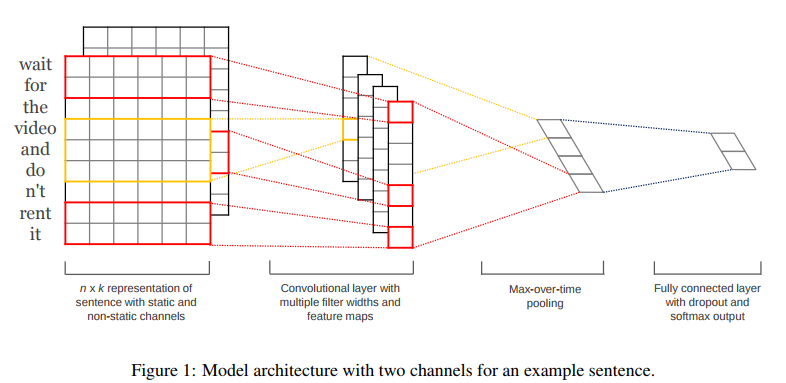

In [13]:
# borrowed image from http://www.aclweb.org/anthology/D14-1181
from IPython.display import Image
Image(filename='../images/08.cnn-for-text-architecture.png')

In [27]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_size, kernel_dim=100, kernel_sizes=(3, 4, 5), dropout=0.5):
        super(CNNClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # kernal_size = (K,D)，定义两个convs层
        self.convs = nn.ModuleList([nn.Conv2d(1, kernel_dim, (K, embedding_dim)) for K in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        # 定义pooling展开后的全连接层
        self.fc = nn.Linear(len(kernel_sizes) * kernel_dim, output_size)

    # 初始化static和non-static层，加载预训练词向量
    def init_weights(self, pretrained_word_vectors, is_static=False):
        self.embedding.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
        if is_static:
            self.embedding.weight.requires_grad = False

    def forward(self, inputs, is_training=False):
        # 1、原始batch处理之后，输入为(N,H)
        # 2、embedding之后，(N,H,W)->(N,1,H,W)，这里N是batch-size，H是句子长度，W是dimension维度
        inputs = self.embedding(inputs).unsqueeze(1)

        # 1、conv后 (N, C_out, H_out, W_out)，后两个维度根据公式自动计算，这里W_out=1
        # 2、squeeze之后，相当于把第三维的W_out=1去掉了，变成(N, C_out, H_out),list长度len(Ks)
        inputs = [F.relu(conv(inputs)).squeeze(3) for conv in self.convs]

        # 1、max_pool1d，因为kernel_size=H_out，所以之后形状变为(N,C_out,1)，再squeeze之后(N,C_out)
        # 2、[(N,C_out), ...]*len(Ks)
        inputs = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in inputs]
        # cat之后 (N,len(Ks)*C_out)
        concated = torch.cat(inputs, 1)
        if is_training:
            concated = self.dropout(concated)
        out = self.fc(concated)
        return F.log_softmax(out, 1)

In [28]:
# class CNNClassifier(torch.jit.ScriptModule):
#     def __init__(self, vocab_size, embedding_dim, output_size, kernel_dim=100, kernel_sizes=(3, 4, 5), dropout=0.5):
#         super(CNNClassifier, self).__init__()

#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         # kernal_size = (K,D)，定义两个convs层
#         self.convs = nn.ModuleList([nn.Conv2d(1, kernel_dim, (K, embedding_dim)) for K in kernel_sizes])
#         self.dropout = nn.Dropout(dropout)
#         # 定义pooling展开后的全连接层
#         self.fc = nn.Linear(len(kernel_sizes) * kernel_dim, output_size)

#     # 初始化static和non-static层，加载预训练词向量
#     def init_weights(self, pretrained_word_vectors, is_static=False):
#         self.embedding.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
#         if is_static:
#             self.embedding.weight.requires_grad = False

#     @torch.jit.script_method
#     def forward(self, inputs, is_training=False):
#         # 1、原始batch处理之后，输入为(N,H)
#         # 2、embedding之后，(N,H,W)->(N,1,H,W)，这里N是batch-size，H是句子长度，W是dimension维度
#         inputs = self.embedding(inputs).unsqueeze(1)

#         # 1、conv后 (N, C_out, H_out, W_out)，后两个维度根据公式自动计算，这里W_out=1
#         # 2、squeeze之后，相当于把第三维的W_out=1去掉了，变成(N, C_out, H_out),list长度len(Ks)
#         inputs = [F.relu(conv(inputs)).squeeze(3) for conv in self.convs]

#         # 1、max_pool1d，因为kernel_size=H_out，所以之后形状变为(N,C_out,1)，再squeeze之后(N,C_out)
#         # 2、[(N,C_out), ...]*len(Ks)
#         inputs = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in inputs]
#         # cat之后 (N,len(Ks)*C_out)
#         concated = torch.cat(inputs, 1)
#         if is_training:
#             concated = self.dropout(concated)
#         out = self.fc(concated)
#         return F.log_softmax(out, 1)

## Train 

It takes for a while if you use just cpu.

In [29]:
EPOCH = 20
BATCH_SIZE = 50
KERNEL_SIZES = [3,4,5]
KERNEL_DIM = 100
LR = 0.001

# import visdom
# #指定Environment：train
# vis = visdom.Visdom(env='train', server='http://10.35.14.42')
# assert vis.check_connection()
# vis.text('Hello World', win='text1')

In [30]:
model = CNNClassifier(len(word2index), 50, len(target2index), KERNEL_DIM, KERNEL_SIZES)
model.init_weights(pretrained_vectors) # initialize embedding matrix using pretrained vectors

if USE_CUDA:
    model = model.cuda()
    
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [31]:
for epoch in range(EPOCH):
    losses = []
    for i,batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        inputs,targets = pad_to_batch(batch)
#         print(inputs[:2])
#         print(targets[:2])
        
        model.zero_grad()
        preds = model(inputs, True)
        
        loss = loss_function(preds, targets)
        losses.append(loss.item())
        loss.backward()
        
        #for param in model.parameters():
        #    param.grad.data.clamp_(-3, 3)
        
        optimizer.step()
        
        if i % 100 == 0:
            print("[%d/%d] mean_loss : %0.5f" %(epoch, EPOCH, np.mean(losses)))
            losses = []
        
#         这里要注意update='append' if epoch > 1 else None，避免覆盖之前的数值
#         vis.line(X=torch.FloatTensor([epoch]), 
#                  Y=torch.FloatTensor([loss.item()]),
#                  win='train', 
#                  update='append' if epoch > 1 else None,
#                  opts={'title': 'train loss'})

[0/20] mean_loss : 1.67370
[1/20] mean_loss : 0.38239
[2/20] mean_loss : 0.15842
[3/20] mean_loss : 0.15272
[4/20] mean_loss : 0.04254
[5/20] mean_loss : 0.02005
[6/20] mean_loss : 0.01678
[7/20] mean_loss : 0.01070
[8/20] mean_loss : 0.00937
[9/20] mean_loss : 0.00780
[10/20] mean_loss : 0.01416
[11/20] mean_loss : 0.01332
[12/20] mean_loss : 0.00216
[13/20] mean_loss : 0.00379
[14/20] mean_loss : 0.00570
[15/20] mean_loss : 0.00856
[16/20] mean_loss : 0.00267
[17/20] mean_loss : 0.00027
[18/20] mean_loss : 0.00216
[19/20] mean_loss : 0.00056


导出模型供cpp使用，这里torch.jit.trace有问题，还没有走通？？？

In [53]:
state = {'net':model.state_dict(), 'optimizer':optimizer.state_dict(), 'epoch':epoch}
model_path = '/Users/wangming/workspace/DeepNLPAndPytorchPractice/cs-224n-pytorch/notebooks/08modelpara.pth'
torch.save(state, model_path) 

In [54]:
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['net'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch'] + 1

In [56]:
# Evaluation mode
model.eval()

# An example input you would normally provide to your model's forward() method.
example = LongTensor([[1044, 3889,  599, 7828, 5340, 1714, 8142, 7369, 4589, 8600, 4365,    0,
            0,    0,    0,    0,    0]])

# # Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(model, example)

# # Save traced model
traced_script_module.save("cnn_text_clf_model.pth")

TypeError: max_pool1d_with_indices(): argument 'kernel_size' (position 2) must be tuple of ints, not Tensor

## Test 

In [41]:
accuracy = 0
for i, batch in enumerate(getBatch(20, test_data)):
    test, targets = pad_to_batch(batch)
    # (batch_size, labels)
    pred = model(test)
#     print(torch.max(pred, 1))
    # torch.max返回元素最大值以及最大值的下标，[1]为下标，刚好是label标记
    pred = torch.max(pred, 1)[1].data
#     print(pred)
    acc = (pred == targets)
    acc = acc.numpy().sum()
    accuracy += acc
    break
print(accuracy/len(test_data) * 100)

3.6630036630036633


## Further topics 

* <a href="https://arxiv.org/pdf/1508.06615.pdf">Character-Aware Neural Language Models</a>
* <a href="https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf">Character level CNN for text classification</a>

## Suggested Reading

* https://blog.statsbot.co/text-classifier-algorithms-in-machine-learning-acc115293278
* <a href="https://arxiv.org/pdf/1607.01759">Bag of Tricks for Efficient Text Classification</a>
* <a href="https://arxiv.org/pdf/1708.02657">Which Encoding is the Best for Text Classification in Chinese, English, Japanese and Korean?</a>